<center><b><font size="5">Extended Higgs sector in radiative neutrino mass models</font></b></center>

## Preamble

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cycler import cycler
import numpy as np
import math
from sympy import *
from scipy.optimize import root, brentq, minimize_scalar
from sympy.abc import tau, sigma, x, D, T, Q, Y, N
T3, sigmaprime = symbols('T3, sigmaprime')

In [2]:
# local packages
import smgroup
from constants import *
smgroup.GUTU1 = False  # we don't work here with GUT-unified value for alpha_1

In [3]:
mHset = [400, 700, 1000]  # we consider these options for Higgs partner

## Decay of generic scalar $H \to VV$ to pair of gauge bosons

### Effective $g_{HVV}$ couplings  and $R_{VV}=\Gamma(H\to VV)/\Gamma(H\to\gamma\gamma)$ ratios

In [4]:
def VVfact(S1, S2, S3):
    """Return dict with part of effective g_VV coupling for H->VV loop decay.
    
    It is the factor in curly braces in g_HVV expressions in the paper. 
    Phase space factors for identical particles accounted for here.
    S1, S2, S3 -- quadratic Dynkin indices of SM gauge groups
    
    """
    gg = S1 + S2
    GG = (2*S3)*(alphas/alpha)*sqrt(Kfactor)
    ZZ = (cw2/sw2)*S2 + (sw2/cw2)*S1
    Zg = sqrt(2)*( (cw/sw)*S2 - (sw/cw)*S1 )
    WW = sqrt(2) * S2 / sw2
    return {'gg':gg, 'GG':GG, 'ZZ':ZZ, 'Zg':Zg, 'WW':WW}


def VVfactW(D=7, Y=0, real=True, wght=False):
    """Return dict with part of effective g_VV coupling for H->VV loop decay due to additional scalar SM irrep.
    
    Phase space factors for identical particles accounted for here.
    D - dimension of additional scalar irrep
    Y - hypercharge of additional scalar irrep
    real - is the BSM scalar irrep real?
    wght --- T3-weight factor entering sum over multiplet
    
    """
    r, wNC, wCC = (1, 1, 1)
    if real:
        r = 2
    if wght:
        # Weights for CKP model quintuplet scalars which don't
        # couple universally to H
        wNC = (2-T3)/4
        wCC = (3-2*T3)/8  # average of (2-T3)/4 and (1-T3)/4
    T = (D-S(1))/2  # weak isospin
    gg = summation((wNC*Q**2).subs(Q,T3+Y/2).evalf(), (T3, -T, T))/r
    GG = 0
    ZZ = summation((wNC*(T3-sw2*Q)**2).subs(Q,T3+Y/2).evalf(), (T3, -T, T))/sw2/cw2/r
    Zg = sqrt(2)*summation((wNC*Q*(T3-sw2*Q)).subs(Q,T3+Y/2).evalf(), (T3, -T, T))/sw/cw/r
    WW = sqrt(2) * summation((wCC*(T-T3)*(T+T3+1)/2).evalf(), (T3, -T, T))/sw2/r
    return {'gg':gg, 'GG':GG, 'ZZ':ZZ, 'Zg':Zg, 'WW':WW}

In [5]:
def RVV(reps, prt=False):
    """Ratios of widths for H -> VV={GG, Zg, ZZ, WW} w.r.t. H->gamma-gamma.
    
    reps -- specified as in smgroup package
     prt -- besides returning, print out formatted result
    
    """
    VVs = VVfact(*smgroup.SMDynkin(reps))
    gg = VVs['gg']
    RGG = float((VVs['GG']/gg)**2)
    RZg = float((VVs['Zg']/gg)**2)
    RZZ = float((VVs['ZZ']/gg)**2)
    RWW = float((VVs['WW']/gg)**2)
    if prt:
        print("RGG = {:.3f}, RZg = {:.3f},  RZZ = {:.3f},   RWW  = {:.3f}".format(RGG,
            RZg, RZZ , RWW)  )
    return RGG, RZg, RZZ, RWW

In [6]:
# Check 1
res = RVV([smgroup.RealScalar(1,7,0)], prt=True)

RGG = 0.000, RZg = 6.547,  RZZ = 10.716,   RWW  = 36.526


This agrees with table  below Fig. 4 of Strumia's [arXiv:1605.09401](http://www.arXiv.org/pdf/1605.09401), which has RZg=7, RZZ=12, RWW=40. We can reproduce second row of his table with some SU(2) singlet:

In [7]:
# Check 2
res = RVV([smgroup.ComplexScalar(1,1,-1)], prt=True)

RGG = 0.000, RZg = 0.611,  RZZ = 0.093,   RWW  = 0.000


### Expressions for $h\to VV$ and $H\to VV$ partial widths

Standard textbook formulas for SM Higgs decay to two photons:

$$\Gamma(h\to\gamma\gamma) = B \left|\sum_i Q_i^2 A_{i}(\tau_i) \right|^2$$
$$ B = \frac{\alpha^2 g^2 m_h^3}{1024 \pi^3 m_W^2} = \frac{G_F \alpha^2 m_h^3}{
128\sqrt{2} \pi^3}$$
$$\tau_i = \frac{4m_i^2}{m_{H}^2} $$
$$A_{0}(\tau) = -\tau(1-\tau f(\tau)) \to \frac{1}{3}  \quad \text{for} \quad \tau\to\infty$$
$$A_{1/2}(\tau) = 2\tau\big(1+(1-\tau)f(\tau)\big) = 2 + (4 m^2 -m_{H}^2)C_0(0,0,m_{H}^2,m^2,m^2,m^2)$$
$$f(\tau) = \arcsin^2(\sqrt{\frac{1}{\tau}})  \quad \text{for} \quad \tau\ge 1$$
$$f(\tau) = -\frac{m_H^2}{2} C_0 (0,0,m_H^2; m, m, m) $$

In [8]:
# Loop functions

def f(tau):
    return asin(1/sqrt(tau))**2

def A0(tau):
    return -tau*(1-tau*f(tau))

def A1(tau):
    return -2-3*tau-3*tau*(2-tau)*f(tau)

def A12(tau):
    return 2*tau*(1+(1-tau)*f(tau))

In [9]:
# numpy-approved versions of loop functions
fN = lambdify(x, f(x), 'numpy')
A0N = lambdify(x, A0(x), 'numpy')
A1N = lambdify(x, A1(x), 'numpy')
A12N = lambdify(x, A12(x), 'numpy')

def tauN(m, mH):
    return 4*m**2/mH**2

In [10]:
print(" A0 --> {}".format(limit(A0(tau), tau, oo)))
print("A12 --> {}".format(limit(A12(tau), tau, oo)))
print(" A1 --> {}".format(limit(A1(tau), tau, oo)))

 A0 --> 1/3
A12 --> 4/3
 A1 --> -7


In [11]:
# Numerical check of the relation of C0 and f(tau):
# LoopTools for mH=125, m=375
# f(m, MH)_LoopTools = 0.028038859
f(tauN(375, 125))

0.0280388592343634

SM $h(125)\to\gamma\gamma$ width in GeV (just W and top contributions)

In [12]:
Bh = (GF * alpha**2 * mh**3)/(128 * sqrt(2) * pi**3).evalf()
Bh * (A1N(tauN(mW,mh)) + 3*(2/3)**2*A12N(tauN(mt,mh)))**2

1.00329023145110e-5

This is about right. (2HDMC gives 0.83e-5 GeV). 

Now we define $H\to VV$ decay widths expressions for generic BSM and separately for ČKP model.

In [13]:
def GAMHVV(VV='gg', 
           BSMfermions=[], BSMscalars=[], gHFF=v, mF=400, gHSS=v, mS=400, mH=750):
    """Return H->VV (pair of gauge bosons) decay width (generic BSM model)
    
    BSMreps -- specification as in smgroup package
       gHFF -- universal coupling of H to BSM fermions
         mF -- mass of loop fermions
       gHSS -- universal coupling of H to BSM scalars
         mS -- mass of loop scalars
         mH -- mass of decaying H
    
    """
    B = float((alpha**2 * mH**3)/(1024 * pi**3).evalf())
    amp = 0
    if BSMfermions:
        VVf = VVfact(*smgroup.SMDynkin(BSMfermions))[VV]
        amp += - (2*gHFF/mF)*VVf*A12N(tauN(mF, mH))
    if BSMscalars:
        VVs = VVfact(*smgroup.SMDynkin(BSMscalars))[VV]  
        amp += - (gHSS/mS**2)*VVs*A0N(tauN(mS, mH))
    return B * amp**2

In [14]:
def GAMHckp(VV='gg', tau=1, sig=1, sigpri=1, mchi=400, mphi=400, mH=750):
    """Decay width of scalar H to pair of gauge bosons (CKP model)"""
    B = float((alpha**2 * mH**3)/(1024 * pi**3).evalf())
    VVtau = VVfactW(D=7, Y=0, real=True)[VV]
    VVsig = VVfactW(D=5, Y=-2, real=False)[VV]
    VVsigpri = VVfactW(D=5, Y=-2, real=False, wght=True)[VV]
    amp = tau*v*VVtau/mchi**2 * A0N(tauN(mchi, mH))
    amp += (sig*v*VVsig/mphi**2 + sigpri*v*VVsigpri/mphi**2) * A0N(tauN(mphi, mH))
    return B * amp**2

In [15]:
GAMHckp('gg'), GAMHckp('WW')

(0.00198329071986041, 0.0353740237419684)

These numbers (0.00198, 0.0354) agree with my older notebook used for initial plots. Another check: CKP model widths with $\sigma'=0$ (i.e. septuplet plus universal quintuplet contributions) can also be calculated with generic function ``GAMHVV``.

In [16]:
[GAMHckp(VV, sigpri=0) for VV in ['gg', 'Zg', 'ZZ', 'WW']]

[0.000968470022007610,
 0.00380749333876153,
 0.00738691723814960,
 0.0242276310052007]

In [17]:
[GAMHVV(VV, BSMscalars=[smgroup.RealScalar(1,7,0), smgroup.ComplexScalar(1,5,-2)], gHSS=v) for VV in ['gg', 'Zg', 'ZZ', 'WW']]

[0.000968470022007610,
 0.00380749333876153,
 0.00738691723814960,
 0.0242276310052007]

## $\Gamma(H\to \gamma \gamma)$ and total $\Gamma_H$ in two models

### One-loop neutrino mass model (BPR)

Running in the loop for $H\to \gamma\gamma$, we have **one BSM Dirac doublet** $E$ with $Y=-1$ (times the number of generations, of course)

In [18]:
bpr = [smgroup.Dirac(1,2,-1)]
smgroup.SMDynkin(bpr)

(1/2, 1/2, 0)

In [19]:
# RVV = BR(H->VV)/BR(H->gamma gamma)
RGGbpr, RZgbpr, RZZbpr, RWWbpr = RVV(bpr, prt=True)

RGG = 0.000, RZg = 0.789,  RZZ = 3.202,   RWW  = 9.131


It is assumed that there are no other important decay channels so BR($H\to\gamma\gamma$) is

In [20]:
# Branching ratio to gamma gamma:
BrBPRgg = GAMHVV('gg', BSMfermions=bpr)/(GAMHVV('gg', BSMfermions=bpr)+GAMHVV('Zg', BSMfermions=bpr)+GAMHVV('ZZ', BSMfermions=bpr)+GAMHVV('WW', BSMfermions=bpr))
BrBPRgg

0.0708054803374501

In [59]:
# Branching ratios to other channels
BrBPRgg * np.array([RWWbpr, RZgbpr, RZZbpr])

array([0.646554535917982, 0.0559004771903842, 0.226739506554183], dtype=object)

Note that this BR doesn't depends on masses and couplings of BSM particles:

In [21]:
GAMHVV('gg', BSMfermions=bpr, gHFF=191, mF=373, mH=200)/(GAMHVV('gg', BSMfermions=bpr, gHFF=191, mF=373, mH=200)+GAMHVV('Zg', BSMfermions=bpr, gHFF=191, mF=373, mH=200)+GAMHVV('ZZ', BSMfermions=bpr, gHFF=191, mF=373, mH=200)+GAMHVV('WW', BSMfermions=bpr, gHFF=191, mF=373, mH=200))

0.0708054803374501

In [22]:
# Total width of H
for mH in mHset:
    gHFF = 50 # typical lambda
    mF = mH/2  # loop fermion mass
    TOT = GAMHVV('gg', BSMfermions=bpr, gHFF=gHFF, mF=mF, mH=mH)+GAMHVV('Zg', BSMfermions=bpr, gHFF=gHFF, mF=mF, mH=mH)+GAMHVV('ZZ', BSMfermions=bpr, gHFF=gHFF, mF=mF, mH=mH)+GAMHVV('WW', BSMfermions=bpr, gHFF=gHFF, mF=mF, mH=mH)
    print('GAM(mH = {} GeV) = {:.2} GeV, GAM/mH = {:.1}%'.format(mH, TOT, TOT/mH*100))

GAM(mH = 400 GeV) = 1.7 GeV, GAM/mH = 0.4%
GAM(mH = 700 GeV) = 3.0 GeV, GAM/mH = 0.4%
GAM(mH = 1000 GeV) = 4.4 GeV, GAM/mH = 0.4%


So we can take narrow-width approximation here.

### Three-loop neutrino mass model (ČKP)

In [23]:
# Factors relevant for H-->gamma gamma
sigmaprime = symbols('sigmaprime')
print(tau*VVfactW(D=7, Y=0, real=True)['gg'])
print(sigma*VVfactW(D=5, Y=-2, real=False)['gg'])
print(sigmaprime*VVfactW(D=5, Y=-2, real=False, wght=True)['gg'])

14*tau
15.0*sigma
12.5*sigmaprime


In [24]:
# Factors relevant for H--> W+ W-  (with sqrt(2)/sw2 factor extracted)
print((tau*VVfactW(D=7, Y=0, real=True)['WW']*sw2/sqrt(2)).evalf())
print((sigma*VVfactW(D=5, Y=-2, real=False)['WW']*sw2/sqrt(2)).evalf())
print((sigmaprime*VVfactW(D=5, Y=-2, real=False, wght=True)['WW']*sw2/sqrt(2)).evalf())

14.0*tau
10.0*sigma
5.0*sigmaprime


One possible check is the known fact that for Y=0 model ratio of WW to $\gamma\gamma$ decay widths is $2/s_{W}^4=36.5$. We have such model for $\sigma=\sigma'=0$.

In [25]:
GAMHckp('WW', sig=0, sigpri=0)/GAMHckp('gg', sig=0, sigpri=0)

36.5256775513186

In [26]:
# Final ratios to gamma gamma channel (RVV) for tau=sig=sigpri
GAMHckp('Zg')/GAMHckp('gg'), GAMHckp('ZZ')/GAMHckp('gg'), GAMHckp('WW')/GAMHckp('gg')

(3.07584023022985, 4.93832776839717, 17.8360254438432)

Unlike BPR model, here we also have posibility of decay to top pair with width:
$$
\Gamma(H\to t\bar{t})= N_c  \frac{\alpha M_H}{8 \sin^2\theta_W} \frac{m_t^2}{m_W^2} \bigg(1-\frac{4 m_t^2}{m_H^2}\bigg)^{3/2}
$$

In [27]:
# Width for H --> t tbar
def GAMHtt(mH):
    return 3*(1/126.5)*mH*mt**2/(8*sw2*mW**2)*(1-tauN(mt, mH))**(3/2)

for mH in mHset:
    print("GAMHtt (mH={} GeV) = {} GeV".format(mH, GAMHtt(mH)))

GAMHtt (mH=400 GeV) = 2.9247546742763135 GeV
GAMHtt (mH=700 GeV) = 27.03644451950882 GeV
GAMHtt (mH=1000 GeV) = 48.61362232007912 GeV


In [28]:
def GAMTOTckp(tau, sig, sigpri, mchi, mphi, mH):
    """Total width of H in CKP model."""
    WW = GAMHckp('WW', tau, sig, sigpri, mchi, mphi, mH)
    ZZ = GAMHckp('ZZ', tau, sig, sigpri, mchi, mphi, mH)
    Zg = GAMHckp('Zg', tau, sig, sigpri, mchi, mphi, mH)
    gg = GAMHckp('gg', tau, sig, sigpri, mchi, mphi, mH)
    TOT = GAMHtt(mH)+WW+ZZ+Zg+gg
    return TOT

In [29]:
def GAMTOTckpD(lam, mS, mH):
    """Total width of H in CKP model with degenerate couplings and mases and BR(gg)."""
    WW = GAMHckp('WW', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    ZZ = GAMHckp('ZZ', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    Zg = GAMHckp('Zg', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    gg = GAMHckp('gg', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    TOT = GAMHtt(mH)+WW+ZZ+Zg+gg
    return TOT, gg/TOT

In [30]:
# mS = mH/2
for mH in mHset:
    TOT, Brgg = GAMTOTckpD(8, mH/2, mH)
    print( "mH = {} GeV, GAMHTOT = {:.1f} GeV;  Br(H-->gg) = {:.3}, GAMTOT/mH = {:.2}%".format(mH, TOT, Brgg, TOT/mH*100) )

mH = 400 GeV, GAMHTOT = 32.6 GeV;  Br(H-->gg) = 0.0339, GAMTOT/mH = 8.2%
mH = 700 GeV, GAMHTOT = 44.0 GeV;  Br(H-->gg) = 0.0144, GAMTOT/mH = 6.3%
mH = 1000 GeV, GAMHTOT = 60.5 GeV;  Br(H-->gg) = 0.00731, GAMTOT/mH = 6.0%


In [31]:
def allBRs(lam, mS, mH):
    """Total width of H in CKP model with degenerate couplings and mases and BR(gg)."""
    WW = GAMHckp('WW', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    ZZ = GAMHckp('ZZ', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    Zg = GAMHckp('Zg', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    gg = GAMHckp('gg', tau=lam, sig=lam, sigpri=lam, mchi=mS, mphi=mS, mH=mH)
    TOT = GAMHtt(mH)+WW+ZZ+Zg+gg
    return TOT, WW/TOT, gg/TOT, Zg/TOT, ZZ/TOT, GAMHtt(mH)/TOT 

allBRs(8, 350, 700)

(44.0080434579560,
 0.256177724518669,
 0.0143629378263249,
 0.0441781019905003,
 0.0709288947035026,
 0.614352340961003)

## Production of $H$ and $\sigma(p p \to H \to V V)$

### Experimental bound on $\sigma(pp\to H\to \gamma\gamma)$

This can be read from Fig. 7 of [ATLAS](https://inspirehep.net/record/1480039/files/ATLAS-CONF-2016-059.pdf).
For the one-loop model, we can work within narrow-width approximation and we have:


In [32]:
##  mH/GeV -> xs_bound/fb
xs13gg_bound_NWA = {400: 1.8, 500: 1., 700: 1.4, 750: 0.62, 800:1, 1000: 0.45}

For three-loop model, where $H$ decays also to $t\bar{t}$, width of $H$ is large enough that narrow-width approximation is not O.K., so we take the following bounds from ATLAS plot with $\Gamma_H/m_H = 6\,\%$:

In [33]:
##  mH/GeV -> xs_bound/fb
xs13gg_bound_6perc = {400: 3.7, 500: 2.7, 700: 4, 750: 3.1, 800:3, 1000: 1.1}

### One-loop model: photon fusion

Dominant production is **photon fusion**. Some expressions and values for photon and parton luminosities can be seen in [Franceschini et al.](http://arXiv.org/pdf/1512.04933). But it is not clear how they obtain their value for $C_{\gamma\gamma}$. Using some available parton sets which include photon PDFs, one gets wildly different values. 

For production via **photon fusion** $pp \to \gamma \gamma \to H \to \gamma \gamma$ at 13 TeV, [Harland-Lang et al.](http://arXiv.org/abs/1601.07187) have

$$ \sigma = 4.1\,{\rm pb}\, \left(\frac{\Gamma_H}{45\, {\rm GeV}}\right) {\rm Br}(H\to\gamma\gamma)^2$$

while [Csaki et al.](http://arXiv.org/abs/1601.00638) have

$$ \sigma = 10.8 \,{\rm pb}\, \left(\frac{\Gamma_H}{45\, {\rm GeV}}\right) {\rm Br}(H\to\gamma\gamma)^2$$.

They both include elastic and inelastic contributions, the latter also mixed, and in narrow width approximation. We can read values of photon luminosity from Fig.1 of
the first reference

|  M/GeV   | dL/dM^2  |
|  ----    | -----    |  
|    400   |  8   pb  | 
|    500   |  3.5 pb  |
|    700   |  1.2 pb  |
|    750   |  0.85 pb |
|    800   |  0.7 pb  |
|   1000   |  0.3 pb  |

The differential luminosity in second column then enters the total cross-section like this
$$
\sigma(pp\to H\to \gamma\gamma) = \frac{8\pi^2}{M_H} \left.\frac{d\mathcal{L}^{\rm inc}_{\gamma\gamma}}{dM^2}\right|_{M=M_H} \Gamma(H\to\gamma\gamma)\;  {\rm Br}(H\to\gamma\gamma)
$$

In [34]:
# M --> Prefactor in Eq (12) of Harland-Lang et al. in fb
HLang = {}
for M, lum in [(400, 8), (500, 3.5), (700, 1.2), (750, 0.85), (800, 0.7), (1000, 0.3)]:
    HLang[M] = 8*np.pi**2*lum/M * 1000
HLang[750]   # H-Lang et al. have 91 fb in their Eq. (12)

89.4844132365435

Allowed coupling of H to loop fermion is constrained by the ATLAS bound on $\sigma(pp\to H\to \gamma\gamma)$ which transforms to bound on $\Gamma_{H\to\gamma\gamma}$ like (note that branching ratio is independent of this coupling)
$$\Gamma_{H\to\gamma\gamma} < \frac{\sigma(pp\to H\to \gamma\gamma)_{\rm bound}}
{\frac{8\pi^2}{M_H} \left.\frac{d\mathcal{L}^{\rm inc}_{\gamma\gamma}}{dM_{X}^2}\right|_{M_X=M_H} {\rm Br}(H\to\gamma\gamma)}$$


In [35]:
def lam(msig, mH, GAM):
    """Coupling needed to get given width for H->gamma gamma.
    
       GAM -- partial decay width H->gamma gamma
      msig -- mass of loop fermion (m_E)
        mH -- mass of H
      
    """
    ss = ( sqrt(256 * pi**3 * GAM / (alpha**2 * mH**3)) ).evalf()
    return float(msig * ss / A12N(tauN(msig, mH)))

# numpy-approved version of same function
lamN = np.frompyfunc(lam, 3, 1)

In [36]:
# Checking that above inverted formula lambda(sigma) is consistent
# with "master" formula sigma(lambda):
lamN(500, 900, GAMHVV('gg', BSMfermions=bpr, gHFF=42, mF=500, mS=500, mH=900))

42.00000000000001

In [37]:
def lam_from_xs(msig, mH=750, dlumi=0.8, xs=1, reps=bpr):
    """Value of gHFF resulting in xs(pp->H->gg)."""
    # BrBPRgg is fixed at 7%
    GAMgg = xs/dlumi/BrBPRgg
    return lamN(msig, mH, GAMgg)

In [38]:
def lamboundBPR(msig, mH):
    """Bound on BPR model's lambda to violate 13 TeV xs(pp->H->VV) constraint"""
    # BrBPRgg is fixed at 7%
    GAMgg = xs13gg_bound_NWA[mH]/HLang[mH]/BrBPRgg
    return lamN(msig, mH, GAMgg)

In [39]:
lamboundBPR(400, 750)

38.30081166700351

### Three-loop model: gluon fusion

Higgs production by **gluon-gluon fusion**: 7 and 8 TeV by  [LHC Higgs xs WG](http://arXiv.org/pdf/1307.1347), and 13 TeV by [gluon luminosity ratios](https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageAt1314TeV2014) (13 TeV/8 TeV) 

| mH/GeV | 7 TeV    |  8 TeV   | 13/8 Glumi | 13 TeV
|  ----  | -----    |  ------  | -----      | -----
| 125    | 15.13 pb |  19.27 pb|  2.296     | 44.2 pb
| 400    | 2.047 pb |   2.92 pb|  3.31      |  9.66 pb
| 500    | 870 fb   |   1.28 pb|  3.68      |  4.71 pb
| 700    | 147 fb   |  229 fb  |  4.48      |  1.03 pb
| 750    |  99 fb   |  157 fb  |  4.693     | 737 fb
| 800    |  69 fb   |  110 fb  |  4.92      | 541 fb
| 1000   |  19 fb   |   32 fb  |  4.9       | 157 fb

and we have e.g. for $M_H = 700 GeV$ in the narrow width approximation

$$\sigma_{\gamma\gamma} = 1030 \, {\rm fb}\; Br(H\to\gamma\gamma)$$

In [40]:
# xs(pp -> GG -> H) at 13 TeV
ggF13 = {125: 44200., 400: 9660., 500: 4710., 
         700: 1030., 750: 737., 800: 541., 1000: 157.}

In [41]:
def xs13CKP(VV, tau, sig, sigpri, mchi, mphi, mH):
    """xs(pp --> H --> VV)/fb at 13 TeV in CKP model"""
    TOT = GAMTOTckp(tau, sig, sigpri, mchi, mphi, mH)
    BrVV = GAMHckp(VV, tau, sig, sigpri, mchi, mphi, mH)/TOT
    # print('GAMH = {:.1f} GeV, Br(H->{}) = {}'.format(TOT, VV, BrVV))
    return ggF13[mH] * BrVV

In [42]:
def fun(VV, tau, sig, mH):
    """
    f(tau)=(xs(tau) - xsbound) 
    
    Zero of this function determines boundary values of tau or sig.
    """
    assert VV == 'gg'  # only diphoton channel bound implemented
    mS = mH/2  # loop scalar mass for strongest effect
    return xs13CKP(VV, tau=tau, sig=sig, sigpri=sig, mchi=mS, mphi=mS, mH=mH) - xs13gg_bound_6perc[mH]

In [43]:
def sigboundCKP(VV, tau, mH, cut=30):
    """Two boundary values of sig=sig' to violate 13 TeV xs(pp->H->VV) constraint"""
    assert VV ==  'gg'  # only diphoton channel bound implemented
    # there are two zeros: one in (-cut,min) and another in (min, cut)
    mnm = minimize_scalar(lambda s: fun(VV, tau, s, mH)).x  # minimum
    lowb = brentq(lambda s: fun(VV, tau, s, mH), -cut, mnm)
    highb = brentq(lambda s: fun(VV, tau, s, mH), mnm, cut)
    return lowb, highb

In [44]:
def funm(VV, mchi, mphi, mH):
    """
    f(tau)=(xs(tau) - xsbound) 
    
    Zero of this function determines boundary values of mchi or mphi.
    couplings are fixed tau=sig=sigpri=10 !
    """
    assert VV == 'gg' # only diphoton channel bound implemented
    return xs13CKP(VV, tau=10, sig=10, sigpri=10, mchi=mchi, mphi=mphi, mH=mH) - xs13gg_bound_6perc[mH]

In [45]:
def mboundCKP(VV, mchi, mH, init=390, method='hybr'):
    assert VV == 'gg'
    """Boundary value of mphi to violate 13 TeV xs(pp->H->VV) constraint"""
    return root(lambda mphi: funm(VV, mchi, mphi, mH), init, method=method).x[0]

## Plots

In [46]:
SAVEPDFS = False

In [47]:
# Order of line colors and styles
plt.rc('axes', prop_cycle=(cycler('color', ['k', 'b', 'r']) +
                           cycler('linestyle', [':', '--', '-'])+
                           cycler('linewidth', [2, 1, 1])))

### [Fig. 1a] Enhancement of $h(125)\to\gamma\gamma$ in one-loop BRP model

Enhancement from the lighter of two charged components of triplet scalar (cf. Eq. (10) from Brdar et al.). Limits come from arXiv:1606.02266 Table 13, combined ATLAS+CMS 7 and 8 TeV data.

In [48]:
Rggup = 1.33
Rggdn = 0.96

In [49]:
def Rgg(lam=1, m=375):
    """Triplet scalar h(125)->gamma gamma enhancement."""
    SM = A1N(tauN(mW,mh)) + 3*(2/3)**2*A12N(tauN(mt,mh))
    BSM = lam * v**2 * A0N(tauN(m,mh)) / (2 * m**2)
    return (1 + BSM/SM)**2

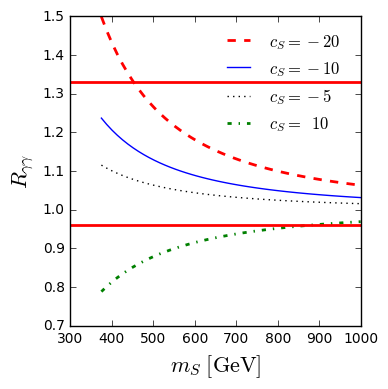

In [50]:
ms = np.linspace(375, 1000)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ms, Rgg(lam=-20, m=ms), 'r--', label=r"$c_S=-20$")
ax.plot(ms, Rgg(lam=-10, m=ms), 'b-', label=r"$c_S=-10$")
ax.plot(ms, Rgg(lam=-5, m=ms), 'k:', label=r"$c_S=-5$")
ax.plot(ms, Rgg(lam=10, m=ms), 'g-.', label=r"$c_S=\;\;10$")
#ax.plot(ms, Rgg(lam=20, m=ms), label=r"$c_S=\;\;20$")
ax.set_xlabel(r'$m_S \;{\rm [GeV]}$', fontsize=16)
ax.set_ylabel(r"$R_{\gamma\gamma}$", fontsize=16)
props = dict(color="red", linestyle="-", linewidth=2)
ax.axhline(Rggdn, **props)
ax.axhline(Rggup, **props)
ax.legend(loc=(0.5, 0.6)).draw_frame(0)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig("/home/kkumer/h125gg.pdf")

### [Fig 1b] $H\to\gamma\gamma$ in one-loop BRP model

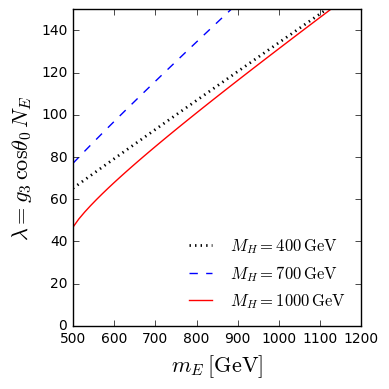

In [51]:
xmin, xmax = 500, 1200
ymin, ymax = 0, 150
ms = np.linspace(xmin, xmax)
fig, ax = plt.subplots(figsize=(4,4))
for mH in mHset:
    ms = np.linspace(max(xmin,mH/2), xmax)
    lamgg = lamboundBPR(ms, mH).astype(np.float)
    lgg, = ax.plot(ms, lamgg, label=r"$M_H = {}\,{{\rm GeV}}$".format(mH))
ax.set_ylabel(r'$\lambda = g_3\, \cos\theta_0\, N_E$', fontsize=16)
ax.set_xlabel(r'$m_{E}\:{\rm [GeV]}$', fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.legend(loc=4).draw_frame(0)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig("/home/kkumer/triplet.pdf")

### [Fig 2] $\Gamma_{H}$ in three-loop ČKP model

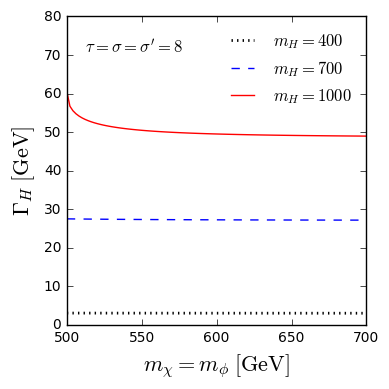

In [52]:
sgma = 8  # = tau
resolution = 100
xmin, xmax = 500, 700
ymin, ymax = 0, 80
plt.figure(figsize=(4,4))
for mH in mHset:
    xs = np.linspace(max(xmin,mH/2),xmax, resolution)
    TOT, BR = GAMTOTckpD(sgma, xs, mH)
    plt.plot(xs , TOT, label=r"$m_{{H}} = {}$".format(mH))
plt.ylabel(r'$\Gamma_H\;{\rm [GeV]}$', fontsize=16)
plt.xlabel(r'$m_{\chi}=m_{\phi}\;{\rm [GeV]}$', fontsize=16)
plt.annotate(r"$\tau=\sigma=\sigma' = 8$", xy=(0.06, 0.88), xycoords='axes fraction', fontsize=12)
plt.legend(loc=1).draw_frame(0)
plt.xlim(xmin, xmax)
fig = plt.ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig('/home/kkumer/diphGAMm.pdf')

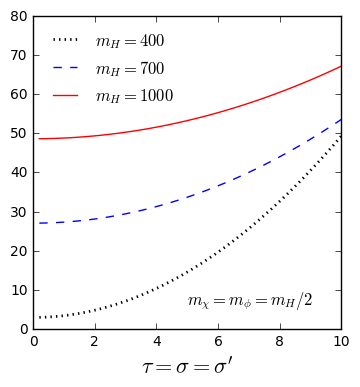

In [53]:
xmin, xmax = 0.2, 10
plt.figure(figsize=(3.7,4))
for mH in mHset:
    xs = np.linspace(xmin, xmax, 40)
    TOT, BR = GAMTOTckpD(xs, mH/2, mH)
    plt.plot(xs , TOT, label=r"$m_{{H}} = {}$".format(mH))
#plt.ylabel(r'$\sigma(pp\to H\to\gamma\gamma)\;{\rm [fb]}$', fontsize=16)
plt.xlabel(r"$\tau=\sigma=\sigma'$", fontsize=16)
#plt.fill_between(xs, xs_low*np.ones(xs.shape), xs_high*np.ones(xs.shape), facecolor='lightgreen', alpha=0.5)
#plt.text(2.5, 8, r'${\rm ATLAS+CMS}\; \gamma\gamma\; {\rm range}$')
plt.annotate(r'$m_\chi = m_\phi = {m_H}/{2}$', xy=(0.50, 0.08), xycoords='axes fraction', fontsize=12)
plt.legend(loc=2).draw_frame(0)
#plt.xlim(xmin, xmax)
fig = plt.ylim(ymin, ymax)
plt.tight_layout()
if SAVEPDFS:
    plt.savefig('/home/kkumer/diphGAMlam.pdf')

### [Fig. 3] Allowed mass/coupling parameter ranges for ČKP model

In [54]:
resolution = 15  # of calculation grid 
bmax=20
xs = np.linspace(-bmax, bmax, resolution)
bounds = {}
for mH in mHset:
    bounds[mH] = np.transpose([sigboundCKP('gg', t, mH) for t in xs])

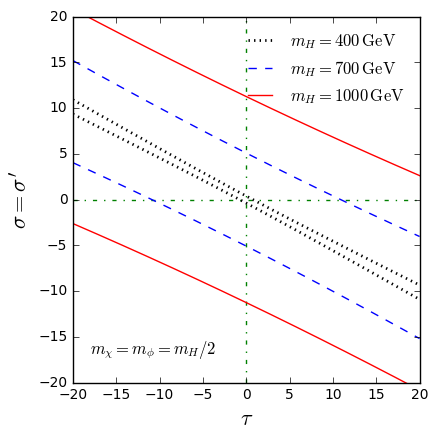

In [55]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel(r"$\sigma=\sigma'$", fontsize=16)
props = dict(color="green", linestyle="-.", linewidth=1)
ax.axvline(x=0, **props)
ax.axhline(y=0, **props)
for mH in mHset:
    lowb, hib = bounds[mH]
    lnL, = plt.plot(xs, lowb, label=r'$m_H = {}\,{{\rm GeV}}$'.format(mH))
for mH in mHset:
    lowb, hib = bounds[mH]
    lnL, = plt.plot(xs, hib)
#ax.fill_between(xs, -bmax, gs, color='gray', alpha='0.6')
#ax.fill_between(xs, gs, bmax, color='gray', alpha='0.6')
ax.legend(loc=1).draw_frame(0)
plt.tight_layout()
fig = plt.ylim(-bmax, bmax)
# Put labels on exclusion lines
#label_line(lggL, r"$\gamma\gamma$", near_x=-12)
#label_line(lggH, r"$\gamma\gamma$", near_x=12)
ax.annotate(r'$m_\chi = m_\phi = m_H/2$', xy=(0.05, 0.08), xycoords='axes fraction', fontsize=12)
if SAVEPDFS:
    plt.savefig("/home/kkumer/tausig.pdf")

For $m_H = 1000$ GeV, digamma constraint is just in the corner around $m_\phi \approx m_\chi \approx 500$ GeV, since for lower masses tree-level decay to two scalars opens ...

In [56]:
print('Bound on digamma xs = {} GeV'.format(xs13gg_bound_6perc[1000]))
xs13CKP('gg', tau=10, sig=10, sigpri=10, mchi=590, mphi=500, mH=1000)

Bound on digamma xs = 1.1 GeV


1.10674462753399

.. so we don't plot 1000 GeV line.

In [57]:
resolution = 15  # of calculation grid 
xmin = 400
xmax = 650
mbounds = {}
for mH in mHset[:-1]:
    xs = np.linspace(xmin, xmax, resolution)
    mbounds[mH] = [mboundCKP('gg', m, mH, init=mH/2.+10) for m in xs]

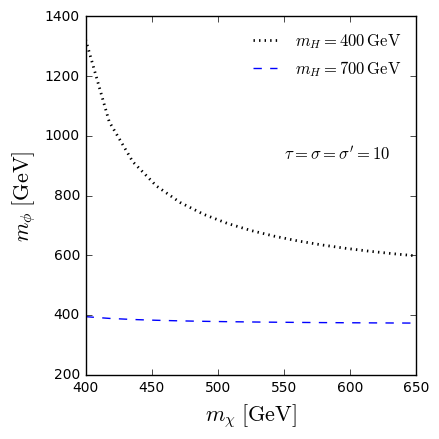

In [58]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
#ax.annotate(r"$\tau=\sigma=\sigma' = 10$", xy=(0.6, 0.88), xycoords='axes fraction', fontsize=14)
ax.set_xlabel(r'$m_\chi \; {\rm [GeV]}$', fontsize=16)
ax.set_ylabel(r"$m_\phi \; {\rm [GeV]}$", fontsize=16)
for mH in mHset[:-1]:
    xs = np.linspace(xmin, xmax, resolution)
    lgg, = ax.plot(xs, mbounds[mH], label=r'$m_H = {}\,{{\rm GeV}}$'.format(mH))
#ax.fill_between(xs, 375, gs, color='gray', alpha='0.6')
ax.legend(loc=1).draw_frame(0)
plt.tight_layout()
plt.annotate(r"$\tau=\sigma=\sigma' = 10$", xy=(0.6, 0.6), xycoords='axes fraction', fontsize=12)
fig = plt.ylim(200, 1400)
if SAVEPDFS:
    plt.savefig("/home/kkumer/mm.pdf")